In [1]:
import numpy as np
import scipy.stats as sps
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=1.5, palette='Set2')

# Задача 5

Случайный вектор $V = (X, Y, Z)$ определяется следующим образом
	$$X = \varepsilon_1,$$
	$$Y = \alpha X + \varepsilon_2,$$
	$$Z = \beta Y + \gamma X + \varepsilon_3,$$
	где $(\varepsilon_1, \varepsilon_2, \varepsilon_3) \sim \mathcal{N}(0, I_3)$.

In [5]:
alpha = 2
beta = 1
gamma = 1.5

### 1. Условное мат. ожидание $\mathsf{E}(Z | Y = y)$:

Посторим функцию для генерации $V$.

In [6]:
def rvs_V(size=1, alpha=1, beta=1, gamma=1):
    """
    Функция, генерирующая выборку размера size случайных векторов V
    Параметры
    ----------
    size : int, optional
        Количество генерируемых величин
    alpha : int, optional
        Параметр для генерации случайной величины Y
        $P(Y|X=x) \sim \mathcal{N}(\alpha x, 1)$
    beta : int, optional
        Параметр для генерации случайной величины Z
    gamma : int, optional
        Параметр для генерации случайной величины Z
        $P(Z|X=x, Y=y) \sim \mathcal{N}(\beta y + \gamma x, 1)$
    Returns
    -------
    V : np.arrray
        матрица размером (size, 3)
    """
    
    x = sps.norm(loc=0, scale=1).rvs(size=size)
    y = alpha * x + sps.norm(loc=0, scale=1).rvs(size=size)
    z = beta * y + gamma * x + sps.norm(loc=0, scale=1).rvs(size=size)
    
    V = np.vstack([x, y, z]).T
    return V

Теперь же попробуем 2 способами с помощью Монте-Карло получить $\mathsf{E}(Z | Y = y)$, причем сразу 2 способами.

**1 способ:**

Идея следующая: 

* Нагенерируем выборку $V$.

* Создадим сетку возможных значений для $Y$ (то есть значения $y$).

* Для каждого значения $y$ из сетки ищем среди насемплированных значений $V$ такие элементы, для которых значения по оси $Y$ отличаются от $y$ не более чем на `eps` (то есть можно считать, что значения внутри этого интервала равны $y$).

* По отобранным на предыдущем шаге элементам из выборки $V$ берем среднее по $Z$.

In [7]:
def get_conditional_expectation_1_method(
    size=10000000, target_index=2, condition_index=1, alpha=1, beta=1, 
    gamma=1,condition_min_val=-3, condition_max_val=3, eps=0.0005
):
    """
    Функция, рассчитывающая значение 
    $\mathbb{E}(V[target_index] | V[condition_index] = value)$
    где value из (condition_min_val condition_max_val)
    Параметры
    ----------
    size : int, optional
        Количество генерируемых величин, чем больше, тем точнее
    target_index : int, optional
        индекс вектора, по которому считается матож
    condition_index : int, optional
        индекс вектора, который является условной величиной
    alpha : int, optional
        Параметр для генерации случайной величины Y
        $P(Y|X=x) \sim \mathcal{N}(\alpha x, 1)$
    beta : int, optional
        Параметр для генерации случайной величины Z
    gamma : int, optional
        Параметр для генерации случайной величины Z
        $P(Z|X=x, Y=y) \sim \mathcal{N}(\beta y + \gamma x, 1)$
    condition_min_val : float, optional
        Граница интервала
    condition_max_val : float, optional
        Граница интервала
    eps : float, optional
        радиус промежутка, внутри которого значения считаются одинаковыми
    Returns
    -------
    conditional_expectation : np.arrray
        массив размером 1000, итоговый условный матож
    condition_grid : np.arrray
        Сетка, по которой берутся значения условной величины 
    """
    
    # 1. Сгенерируем выборку V
    sample_v = rvs_V(size=size, alpha=alpha, beta=beta, gamma=gamma)
    
    # 2. Создадим сетку параметров 
    condition_grid = np.linspace(condition_min_val, condition_max_val, 1000)
    conditional_expectation = []
    
    # 3. пройдемся циклом по значениям condition_value
    for condition_value in tqdm(condition_grid):
        # 4. Смотрим, какие значения в condition_index из семплированных 
        # достаточно близки к condition_value, 
        # что можно сказать, что они "равны"
        # берем индексы этих элементов
        indexes = np.abs(sample_v[:, condition_index] - condition_value) < eps
        
        # 5. считаем среднее по target_index среди тех элементов, 
        # где насемплированные значения по condition_index равны condition_value
        conditional_expectation.append(sample_v[indexes, target_index].mean())
            
    return np.array(conditional_expectation), condition_grid

In [8]:
conditional_expectation_1_method, condition_grid =\
    get_conditional_expectation_1_method(size=10000000, alpha=alpha, 
                                         beta=beta, gamma=gamma)

Попробуем теперь получить ответ другим способом.

**2 способ:**

Как было поcчитано в пункте (б) задания 4:

$$
       \begin{align*}
           \mathsf{D} X &= 1\\
           \mathsf{D} Y &= \alpha^2 + 1\\
           \mathsf{D} Z &= (\alpha \beta + \gamma)^2 + \beta^2 + 1\\
           \mathsf{E}[YZ] &= \alpha (\alpha\beta + \gamma) + \beta\\
           \mathsf{E}[XY] &= \alpha \\
           \mathsf{E}[XZ] &= \alpha\beta + \gamma \\
       \end{align*}
$$

Подставив эти значения в матрицу ковариаций для многомерного нормального распределения, мы получим распределение на $V$.

**Код:**

In [9]:
def distribution_V(alpha=1, beta=1, gamma=1):
    """
    Функция для создания распределения V
    Параметры
    ----------
    alpha : int, optional
        Параметр для генерации случайной величины Y
        $P(Y|X=x) \sim \mathcal{N}(\alpha x, 1)$
    beta : int, optional
        Параметр для генерации случайной величины Z
    gamma : int, optional
        Параметр для генерации случайной величины Z
        $P(Z|X=x, Y=y) \sim \mathcal{N}(\beta y + \gamma x, 1)$
    Returns
    -------
    V : sps.multivariate_normal
        Распределение на случайный вектор V
    """

    covariation_matrix = np.array([
        [1, alpha, alpha * beta + gamma],
        [alpha, alpha ** 2 + 1, alpha * (alpha * beta + gamma) + beta],
        [alpha * beta + gamma, alpha * (alpha * beta + gamma) + beta,
         1 + beta ** 2 + (alpha * beta + gamma) ** 2]
    ])
    
    v_dist = sps.multivariate_normal(cov=covariation_matrix)
    return v_dist

Теперь, можно предложить следующий способ для численного подсчета условного мат.ожидания:

* Нагенерерируем равномерно $x$, $z$ равномерно на $(-\infty, +\infty)$ (но так как у нас нормальные величины, то и от -15 до 15 пойдет)
* Будем также, как и в 1 случае, перебирать y.
* Условная плотность равна $p(x,z\:|\:y) = \dfrac{p_V(x, y, z)}{p(y)}$, где $p(y)$ можно рассчитать так: 
 * $p(y) = \int\limits_{-\infty}^{+\infty} \int\limits_{-\infty}^{+\infty} p_V(x, y, z)dxdz$, а значит можно просто взять среднее по плотности во всех точках $x$, $y$, $z$, где $y$ фиксирован.

* Посмотрим на формулу условного мат. ожидания
$$\mathsf{E}(Z\:|\:Y=y) = \int\limits_{-\infty}^{+\infty} \int\limits_{-\infty}^{+\infty}  z\ \dfrac{p_V(x, y, z)}{p(y)}\ dxdz = \dfrac{1}{p(y)}\int\limits_{-\infty}^{+\infty} \int\limits_{-\infty}^{+\infty}  z\ p_V(x, y, z)\ dxdz
$$

* Таким образом, достаточно просто взять среднее плотности, умноженной на $z$, и поделить на среднее только по плотности (по всем значениям $x$, $z$).

In [10]:
def get_conditional_expectation_2_method(
    size=10000000, target_index=2, condition_index=1, alpha=1, beta=1, 
    gamma=1, condition_min_val=-3, condition_max_val=3
):
    """
    Функция, рассчитывающая значение 
    $\mathbb{E}(V[target_index] | V[condition_index] = value)$
    где value из (condition_min_val condition_max_val)
    Параметры
    ----------
    size : int, optional
        Количество генерируемых величин, чем больше, тем точнее
    target_index : int, optional
        индекс вектора, по которому считается матож
    condition_index : int, optional
        индекс вектора, который является условной величиной
    alpha : int, optional
        Параметр для генерации случайной величины Y
        $P(Y|X=x) \sim \mathcal{N}(\alpha x, 1)$
    beta : int, optional
        Параметр для генерации случайной величины Z
    gamma : int, optional
        Параметр для генерации случайной величины Z
        $P(Z|X=x, Y=y) \sim \mathcal{N}(\beta y + \gamma x, 1)$
    condition_min_val : float, optional
        Граница интервала
    condition_max_val : float, optional
        Граница интервала
    Returns
    -------
    conditional_expectation : np.arrray
        массив размером 100, итоговый условный матож
    condition_grid : np.arrray
        Сетка, по которой берутся значения условной величины 
    """

    # 1. Генерируем все случайные величины
    x = sps.uniform(loc=-15, scale=30).rvs(size=size)
    z = sps.uniform(loc=-15, scale=30).rvs(size=size)
    y = sps.uniform(loc=-15, scale=30).rvs(size=size)

    # 2. Создаем сетку
    condition_grid = np.linspace(condition_min_val, condition_max_val, 100)
    conditional_expectation = []

    # 3. пройдемся циклом по значениям condition_value
    for condition_value in tqdm(condition_grid):
        # 4. заменим все значения condition_index в сетке на condition_value
        grid = np.vstack([x, y, z])
        grid[condition_index] = [condition_value] * size
        grid = grid.T
        
        # 5. Посчитаем плотности во всех точках
        pdf = distribution_V(alpha=alpha, beta=beta, gamma=gamma).pdf(grid)
        
        # 6. По формуле выше посчитаем результат
        conditional_expectation.append((z * pdf).mean() / pdf.mean())

    return np.array(conditional_expectation), condition_grid

In [11]:
conditional_expectation_2_method, condition_grid_2 =\
get_conditional_expectation_2_method(size=10000000, alpha=alpha, 
                                     beta=beta, gamma=gamma)

Посмотрим теперь на теоретический результат.

**Теоретический ответ:**

Если посчитать интегралы и помучиться посчитать до конца, то получим следующий ответ:

$\mathsf{E}(Z|Y=y) = \left(\beta + \frac{\alpha\gamma}{1+\alpha^2}\right) y$

In [12]:
def get_conditional_expectation_Z_by_Y_in_theory(
    alpha=1, beta=1, gamma=1, condition_min_val=-3, condition_max_val=3
):
    """
    Функция для подсчета условного матожидания 
    $\\mathbb{E}(Z|Y=y)$ по формуле выше
    """
    
    condition_grid = np.linspace(condition_min_val, condition_max_val, 1000)
    conditional_expectation = (beta + (alpha * gamma) \
                              / (1 + alpha ** 2)) * condition_grid
    return conditional_expectation, condition_grid

In [15]:
conditional_expectation_in_theory, condition_grid =\
get_conditional_expectation_Z_by_Y_in_theory(alpha=alpha, beta=beta, 
                                             gamma=gamma)

Отразим теперь полученные результаты на графике.

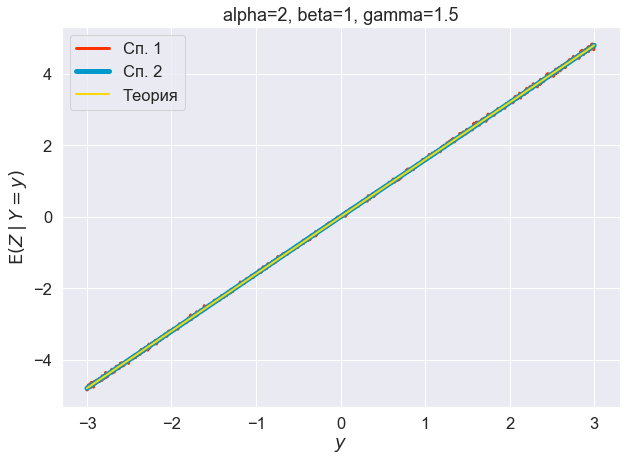

In [16]:
plt.figure(figsize=(10, 7))
plt.title(f"alpha={alpha}, beta={beta}, gamma={gamma}")
plt.plot(condition_grid, 
         conditional_expectation_1_method, lw=3, 
         label='Сп. 1', c='#FF3300')
plt.plot(condition_grid_2, 
         conditional_expectation_2_method, lw=5, 
         label='Сп. 2', c='#0099CC')
plt.plot(condition_grid, 
         conditional_expectation_in_theory, lw=2, 
         label='Теория', c='gold')

plt.ylabel('$\\mathsf{E}(Z\\:|\\:Y=y)$')
plt.xlabel('$y$')
plt.legend();

**Итого:**

* Как видим, все 3 ответа сошлись
* 1 способ при одном и том же количестве нагенерированных значений более шумный в ответе, чем второй.
* Линейную зависимость можно было легко получить на практике, не высчитывая сложных формул


----

### 2. Мат. ожидание при интервенции $\mathsf{E}(Z|Y := y)$

Для начала построим функцию генерации случайного вектора $V$ при фиксированном одном параметре.

In [35]:
def rvs_intervention_V(
    fixed_var_index=1, value=0, size=1, alpha=1, beta=1, gamma=1
):
    """
    Функция, генерирующая выборку размера size случайных векторов V 
    c фиксированным параметром fixed_var_index, в котором установлено значение value
    Параметры
    ----------
    fixed_var_index: int, optional
        Индекс для фиксации
    value : int, optional
        значение в фиксированном параметре
    size : int, optional
        Количество генерируемых величин
    alpha : int, optional
        Параметр для генерации случайной величины Y
        $P(Y|X=x) \sim \mathcal{N}(\alpha x, 1)$
    beta : int, optional
        Параметр для генерации случайной величины Z
    gamma : int, optional
        Параметр для генерации случайной величины Z
        $P(Z|X=x, Y=y) \sim \mathcal{N}(\beta y + \gamma x, 1)$
    Returns
    -------
    V : np.arrray
        матрица размером (size, 3)
    """
    
    x = sps.norm(loc=0, scale=1).rvs(size=size)
    if fixed_var_index == 0:
        x = [value for _ in range(size)]
    y = alpha * x + sps.norm(loc=0, scale=1).rvs(size=size)
    if fixed_var_index == 1:
        y = [value for _ in range(size)]
    z = beta * np.array(y) + gamma * np.array(x) \
        + sps.norm(loc=0, scale=1).rvs(size=size)
    if fixed_var_index == 2:
        z = [value for _ in range(size)]
    
    V = np.vstack([x, y, z]).T
    return V

А далее снова воспользуемся методом Монте-Карло для подсчета мат.ожидания:

* Пройдемся по значениям $y$
* При каждом y насемплируем `size` случайных векторов $V$ с фиксированным $y$
* Посчитаем по ним среднее по $z$

In [18]:
def get_intervention_expectation_monte_karlo(
    size=1000000, target_index=2, intervention_index=1, alpha=1, beta=1, 
    gamma=1, intervention_min_val=-3, intervention_max_val=3
):
    """
    Функция, рассчитывающая значение 
    $\mathbb{E}(V[target_index] | V[intervention_index] := value)$
    где value из (intervention_min_val intervention_max_val)
    Параметры
    ----------
    size : int, optional
        Количество генерируемых величин, чем больше, тем точнее
    target_index : int, optional
        индекс вектора, по которому считается матож
    intervention_max_val : int, optional
        индекс вектора, который является интервенцией
    alpha : int, optional
        Параметр для генерации случайной величины Y
        $P(Y|X=x) \sim \mathcal{N}(\alpha x, 1)$
    beta : int, optional
        Параметр для генерации случайной величины Z
    gamma : int, optional
        Параметр для генерации случайной величины Z
        $P(Z|X=x, Y=y) \sim \mathcal{N}(\beta y + \gamma x, 1)$
    intervention_min_val : float, optional
        Граница интервала
    intervention_max_val : float, optional
        Граница интервала
    Returns
    -------
    intervention_expectation : np.arrray
        массив размером 100, итоговый интервенционный матож
    intervention_grid : np.arrray
        Сетка, по которой берутся значения интервенции
    """
    
    # 1. Создаем сетку
    intervention_grid = np.linspace(intervention_min_val, intervention_max_val, 100)
    intervention_expectation = []
    
    # 2. Итерируемся по значениям для интервенции
    for intervention_value in tqdm(intervention_grid):
        # 3. Семплируем выборку с интервенцией по intervention_index
        sample = rvs_intervention_V(fixed_var_index=intervention_index, 
                                    value=intervention_value,
                                    size=size, alpha=alpha, beta=beta, gamma=gamma)
        # 4. считаем среднее по target_index
        intervention_expectation.append(sample[:, target_index].mean())

    return np.array(intervention_expectation), intervention_grid

In [19]:
intervention_expectation_monte_karlo, intervention_grid =\
get_intervention_expectation_monte_karlo(alpha=alpha, beta=beta, gamma=gamma)

Посмотрим теперь на теоретический результат.

**Теоретический ответ:**

С точки зрения теории, если посчитать интеграл, то получаем следующее:

$ \mathsf{E} (Z\:|\:Y:=y) = \beta y $

In [20]:
def get_intervention_expectation_Z_by_Y_in_theory(
    alpha=1, beta=1, gamma=1, intervention_min_val=-3, intervention_max_val=3
):
    """Функция для подсчета матожидания 
    $\\mathbb{E}(Z|Y:=y)$ по формуле выше"""
    
    intervention_grid = np.linspace(intervention_min_val, 
                                    intervention_max_val, 1000)
    intervention_expectation = beta * intervention_grid
    return intervention_expectation, intervention_grid

In [21]:
intervention_expectation_theory, intervention_grid_theory =\
get_intervention_expectation_Z_by_Y_in_theory(alpha=alpha, beta=beta, 
                                              gamma=gamma)

Отразим теперь полученные результаты на графике.

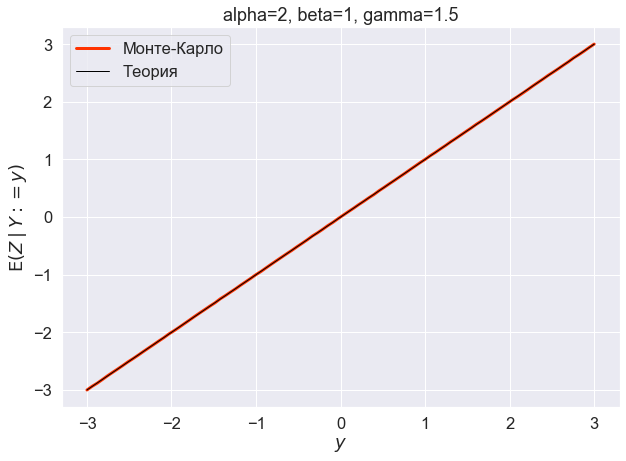

In [22]:
plt.figure(figsize=(10, 7))
plt.title(f"alpha={alpha}, beta={beta}, gamma={gamma}")
plt.plot(intervention_grid, 
         intervention_expectation_monte_karlo, 
         lw=3, label='Монте-Карло', c='#FF3300')
plt.plot(intervention_grid_theory, 
         intervention_expectation_theory, 
         lw=1, label='Теория', c='black')
plt.ylabel('$\\mathsf{E}(Z\\:|\\:Y:=y)$')
plt.xlabel('$y$')
plt.legend();

**Итого:**

* Теоретический ответ снова совпал с реальным
* Линейную зависимость можно было легко получить на практике, не высчитывая сложных формул

### Совместный график:

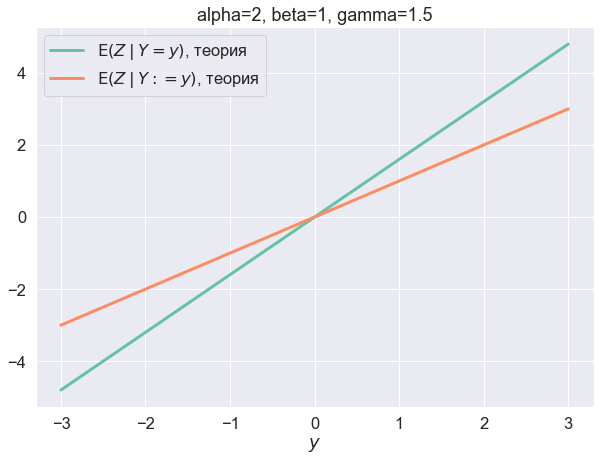

In [23]:
plt.figure(figsize=(10, 7))
plt.title(f"alpha={alpha}, beta={beta}, gamma={gamma}")
plt.plot(condition_grid, conditional_expectation_in_theory, 
         lw=3, label='$\\mathsf{E}(Z\\:|\\:Y=y)$, теория')
plt.plot(intervention_grid_theory, intervention_expectation_theory, 
         lw=3, label='$\\mathsf{E}(Z\\:|\\:Y:=y)$, теория')

plt.xlabel('$y$')
plt.legend();

## Случай $\beta = 0$

Теперь посмотрим на случай, когда $Z$ напрямую не зависит от $Y$ (а только через $X$), то есть $\beta = 0$. Интересно посмотреть, как в этом случае ведут себя мат. ожидания.

In [24]:
beta = 0

In [26]:
conditional_expectation_in_theory, condition_grid =\
    get_conditional_expectation_Z_by_Y_in_theory(alpha=alpha, beta=beta, 
                                                 gamma=gamma)

In [37]:
intervention_expectation_theory, intervention_grid_theory =\
get_intervention_expectation_Z_by_Y_in_theory(alpha=alpha, beta=beta, 
                                              gamma=gamma)

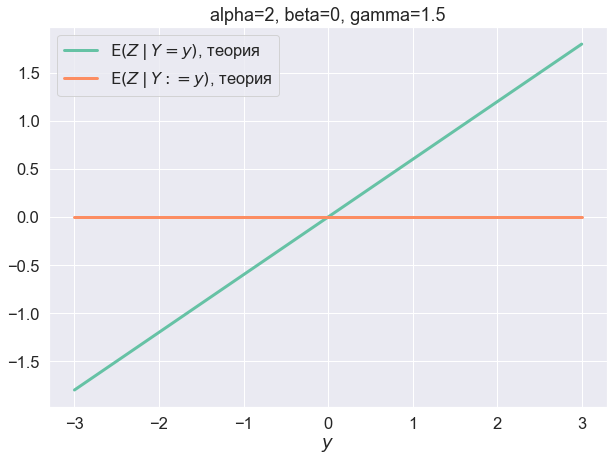

In [39]:
plt.figure(figsize=(10, 7))
plt.title(f"alpha={alpha}, beta={beta}, gamma={gamma}")
plt.plot(condition_grid, conditional_expectation_in_theory, 
         lw=3, label='$\\mathsf{E}(Z\\:|\\:Y=y)$, теория')
plt.plot(intervention_grid_theory, intervention_expectation_theory, 
         lw=3, label='$\\mathsf{E}(Z\\:|\\:Y:=y)$, теория')

plt.xlabel('$y$')
plt.legend();

**Итого:**

* Интервенционное математическое ожидание ведет себя на 0, что с точки зрения здравого смысла больше похоже на правду (раз $X$ и $Z$ симметричны относительно 0 и $Z$ не зависит от $Y$, то мат ожидание должно быть одно и то же и равняться 0).
* С точки зрения условного мат. ожидания, получается, что условное мат. ожидание $Z$ зависит от $Y$ линейно. Зависимость получается из того факта, что обе величины зависят от $X$, а значит связаны друг с другом через $X$.